In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Geometry.rdGeometry import Point3D

import Phe2BCH

import py3Dmol
def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',str(idx))
    molSize = (450, 450)
    return mol

In [2]:
ligands_smi = {}
with open("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/scripts/AaaaA_only5.csv") as AaaaA:
    for line in AaaaA:
        info = line.split()
        ligands_smi[info[1]] = [info[0]]


[19, 26]
[[20, 24], [19, 26], [20, 21, 22, 23, 24, 25]]


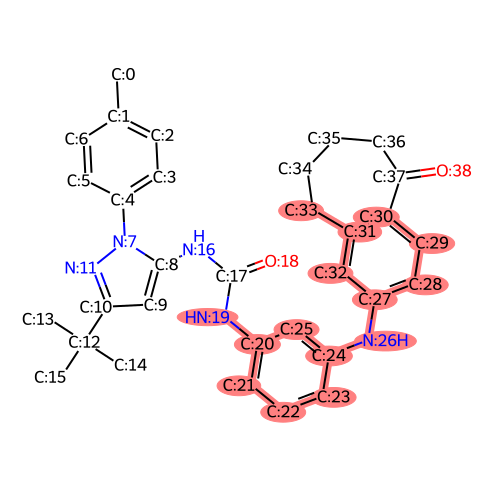

In [3]:
inp="06F_3uvr"
key = inp.split("_")[0]
pdb_id = inp.split("_")[1]
lig_smi = ligands_smi[key][0]
mol = Chem.MolFromSmiles(lig_smi)
patt_sel = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
match_patt = mol.GetSubstructMatches(patt_sel)
print(Phe2BCH.get_connecter(mol,patt_sel))
mol_with_atom_index(mol)

In [7]:
def get_connecter(mol,patt):
    # in fact, this function is able to replace two function above.
    # however, i realise it too later... 
    match_patt = mol.GetSubstructMatches(patt)
    for match_set in match_patt:
        core_connecter = []
        side_connecter = []
        for idx in match_set:
            atom = mol.GetAtomWithIdx(idx)
            neighbors = {neighbor.GetIdx() for neighbor in atom.GetNeighbors()}
            if neighbors & set(match_set) == neighbors:
                if len(list(neighbors)) == 1:
                    side_connecter.append(idx)
                    core_connecter.append(list(neighbors)[0])
                else:
                    pass
            else:
                print(f"neighbors is {neighbors}")
                side_connecter.append(idx)
                for i in list(neighbors):
                    if i in match_set:
                        core_connecter.append(i)
        print(side_connecter)
        if len(side_connecter) == 2:
            return [core_connecter, side_connecter,list(set(match_set)-set(side_connecter))]
        else:
            pass
    return False


[12:46:45] WARNING: More than one matching pattern found - picking one



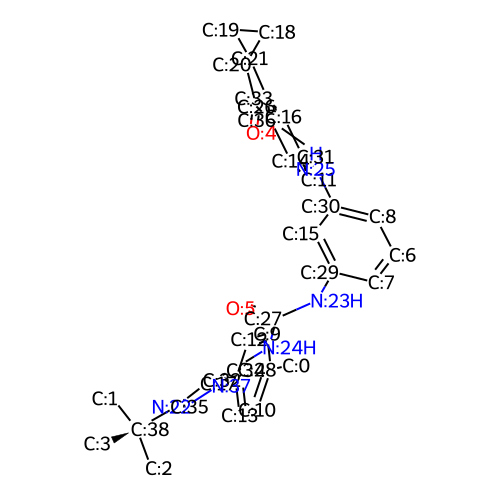

In [5]:
inp="06F_3uvr"
key = inp.split("_")[0]
pdb_id = inp.split("_")[1]
lig_smi = ligands_smi[key][0]
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig = Phe2BCH.exctract_ligand_from_pdb(pdb_path, key, lig_smi, f"{key}_{pdb_id}_phe.pdb")
lig_noH = Chem.RemoveHs(lig)
mol_with_atom_index(lig_noH)
from IPython.display import display
display(lig_noH)

In [10]:

if True:
    drawit(lig_noH)
    conf = lig_noH.GetConformer()
    lig_noH_atoms = lig_noH.GetNumAtoms()
    patt = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
    print(lig_noH.GetSubstructMatches(patt ))
    connect_atoms = get_connecter(lig_noH, patt)
    print(connect_atoms)
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")

    AllChem.EmbedMolecule(re_pat)
    mid_mol = Chem.CombineMols(lig_noH, re_pat)

    mid_edited = Chem.EditableMol(mid_mol)
    mid_edited.AddBond(
        connect_atoms[1][0], lig_noH_atoms, order=Chem.rdchem.BondType.SINGLE
    )
    mid_edited.AddBond(
        connect_atoms[1][1], lig_noH_atoms + 4, order=Chem.rdchem.BondType.SINGLE
    )
    try:
        mid_edited.RemoveBond(connect_atoms[1][0],connect_atoms[0][0])
        mid_edited.RemoveBond(connect_atoms[1][1],connect_atoms[0][1])
    except:
        mid_edited.RemoveBond(connect_atoms[1][0],connect_atoms[0][1])
        mid_edited.RemoveBond(connect_atoms[1][1],connect_atoms[0][0])
    drawit(mid_edited.GetMol())
    phenyl_atoms = connect_atoms[2]
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    drawit(BCHep_mol)
    Chem.SanitizeMol(BCHep_mol)
    conf_gen = BCHep_mol.GetConformer()
    mol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(BCHep_mol)
    if mol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(BCHep_mol, mol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(BCHep_mol)
    for atom in BCHep_mol.GetAtoms():
        atom_idx = atom.GetIdx()
        if atom_idx < lig_noH_atoms - 6:
            ff_mcs.AddFixedPoint(atom_idx)
        elif atom_idx == lig_noH_atoms-6:
            ff_mcs.AddFixedPoint(atom_idx)
            conf_gen.SetAtomPosition(atom_idx, conf.GetAtomPosition(list(connect_atoms[0])[0]))
        elif atom_idx == lig_noH_atoms-2:
            ff_mcs.AddFixedPoint(atom_idx)
            conf_gen.SetAtomPosition(atom_idx, conf.GetAtomPosition(list(connect_atoms[0])[1]))
        else:
            pass
    for i in range(100):
        try:
            ff_mcs.Minimize()
        except:
            pass
    BCHep_mol_H = Chem.AddHs(BCHep_mol, addCoords=True)
    drawit(BCHep_mol_H)




You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

((21, 33, 16, 31, 25, 11, 14, 36), (23, 29, 15, 30, 25, 8, 6, 7))
neighbors is {33, 19}
neighbors is {30, 31}
neighbors is {33, 26, 14}
[21, 25, 36]
neighbors is {27, 29}
neighbors is {30, 31}
[23, 25]
[[29, 30], [23, 25], [6, 7, 8, 15, 29, 30]]


[12:48:53] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[12:48:53] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

O=C1N=c2c(F)cccc2=C1NO


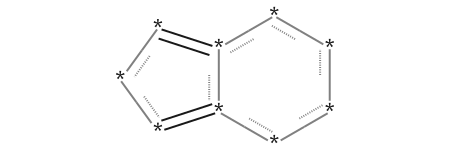

In [29]:
lig_refine_smi = Chem.MolToSmiles(Chem.RemoveAllHs(lig))
print(lig_refine_smi)
mol = Chem.MolFromSmarts("*1*=*2*****2=*1")
mol

In [ ]:
def conf_phe2bch_with_smiles(mol):
    # 用于将给定配体中的*间位苯环骨架*替换为*螺旋桨烷骨架*的脚本
    # 用smi指定ligand的结构
    bonded_conf = mol.GetConformer()
    mol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(mol)
    if mol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(mol, mol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(mol)

    # 读入分子
    # 识别间位取代部分，* 匹配任意原子；'!:' 非芳香键； *!:ccc(!:*)ccc 含间位取代的苯环
    patt = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
    match = mol.GetSubstructMatches(patt)

    # 识别两个间位取代基与苯环的连接原子,识别需要被替换苯环原子
    connect_atoms = Phe2BCH.get_connect_atom_in_sidechain(mol, match[0])
    core = set(match[0]) - set(connect_atoms)

    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()
    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol, re_pat)
    # 开始成键
    mid_edited = Chem.EditableMol(mid_mol)
    # 螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(
        connect_atoms[0], mol1_Atom_num, order=Chem.rdchem.BondType.SINGLE
    )
    mid_edited.AddBond(
        connect_atoms[1], mol1_Atom_num + 4, order=Chem.rdchem.BondType.SINGLE
    )
    # 删除原来的苯环
    # 每删除一个原子后原子序号都会发生改变，所以需要倒序删除。
    phenyl_atoms = list(core)
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    # check mol
    try:
        Chem.SanitizeMol(BCHep_mol)
    except:
        raise ValueError("no match 6-5 rings")
    return BCHep_mol

In [3]:
ligands_smi = {}
with open("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/lig_menu/AaaaA_only3.csv") as AaaaA:
    for line in AaaaA:
        info = line.split()
        ligands_smi[info[1]] = [info[0]]
inp = "11B_2pj5"
key = inp.split("_")[0]
pdb_id=inp.split("_")[1]
lig_smi=ligands_smi[key][0]
# print(lig_smi)
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig_Block = Phe2BCH.exctract_ligand_from_pdb(pdb_path,key,lig_smi,f"{key}_{pdb_id}_sin.pdb")
test = Phe2BCH.phe2bch_topdb(lig_smi,lig_Block,f"{key}_{pdb_id}_bch.pdb")
drawit(test)


[14:28:05] WARNING: More than one matching pattern found - picking one

[14:28:06] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
pdb_view = Chem.MolFromPDBFile("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/scripts/11B_2pj5_bch.pdb")
drawit(pdb_view)

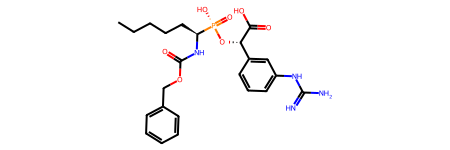

In [9]:
inp = "11B_2pj5"
key = inp.split("_")[0]
pdb_id=inp.split("_")[1]
lig_smi=ligands_smi[key][0]
mol = Chem.MolFromSmiles(lig_smi)
test = Chem.RemoveAllHs(mol)
test

In [9]:
test_block = "".join([line+"\n" for line in Chem.MolToPDBBlock(test).split("\n") if line[0:6] == "HETATM"])
# print(test_block)
test_refine = Chem.MolFromPDBBlock(test_block)
core = Chem.MolFromSmiles("C12CCCC(C2)C1")
test_noH = Chem.RemoveAllHs(test)
side_chains, unmatched = rdRGD.RGroupDecompose([core], [test_refine])
test_res = AllChem.AssignBondOrdersFromTemplate(test_noH,test_refine)
drawit(Chem.AddHs(test_res,addCoords=True))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

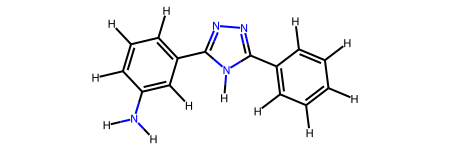

: 

: 

In [ ]:
lig_inp = Chem.MolFromSmiles(lig_smi)
lig_inp = Chem.AddHs(lig_inp)
lig_inp


In [ ]:
lig_Block = Phe2BCH.exctract_ligand_from_pdb(pdb_path,key,lig_smi,"test.pdb")
bonded_conf = lig_Block.GetConformer()
drawit(lig_Block)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

# bug report 
when one sidechain is in the other sidechain, like the example below, the match function wil assign them uncorrectly, which need to debug  

In [ ]:
# begin display
def rename_atom(atom_to_rename, pdbinfo_ref):
    # sometime,
    name = str(atom_to_rename.GetSymbol()) + str(atom_to_rename.GetIdx() + 1)
    if len(name) == 2:
        name = " " + name + " "
    elif len(name) == 3:
        name = " " + name
    elif len(name) == 4:
        pass
    pdbinfo = atom_to_rename.GetPDBResidueInfo()
    if pdbinfo:
        Chem.AtomMonomerInfo.SetName(pdbinfo, name)
        Chem.AtomPDBResidueInfo.SetAltLoc(pdbinfo, " ")
        Chem.AtomPDBResidueInfo.SetResidueNumber(pdbinfo, 1)
    else:
        Chem.Atom.SetMonomerInfo(atom_to_rename, pdbinfo_ref)
        pdbinfo = atom_to_rename.GetPDBResidueInfo()
        Chem.AtomPDBResidueInfo.SetAltLoc(pdbinfo, " ")
        Chem.AtomMonomerInfo.SetName(pdbinfo, name)
    return name
def check_altLoc(altLoc_symbol, lines):
    # sometimes the altLoc in ligands line are not "A"," " or "1"
    # which leads to the pdbparser will ignore them
    # this function will select the ligand lines with the same altLoc.
    if altLoc_symbol == "A" or altLoc_symbol == " " or altLoc_symbol == "1":
        return "".join(lines)
    else:
        lig_Block = ""
        for line in lines:
            if line[16] == altLoc_symbol:
                lig_Block += line
        return lig_Block
def check_triazole_pdb(mol_pdb, smi):
    # sometimes the PDBparser will connect atoms uncorrectly
    # this function will remove the extra bond of the atom of "CN1N=NC=C1"
    mol_check = Chem.MolFromSmiles(smi)
    triazole = Chem.MolFromSmiles("CN1N=NC=C1")
    match_triazole = mol_check.GetSubstructMatch(triazole)
    if not match_triazole:
        return mol_pdb
    else:
        conf = mol_pdb.GetConformer()
        mol_edited = Chem.EditableMol(mol_pdb)
        dist_Idx = []
        for atom in mol_pdb.GetAtoms():
            atom_symbol = atom.GetSymbol()
            neighors = atom.GetNeighbors()
            if atom_symbol == "N" and len(neighors) > 3:
                N_idx = atom.GetIdx()
                dist_Idx = [
                    (
                        Point3D.Distance(
                            conf.GetAtomPosition(item.GetIdx()),
                            conf.GetAtomPosition(N_idx),
                        ),
                        item.GetIdx(),
                    )
                    for item in neighors
                ]
        if len(dist_Idx) > 0:
            dist_Idx.sort()
            mol_edited.RemoveBond(N_idx, dist_Idx[-1][1])
            return mol_edited.GetMol()
        else:
            return mol_pdb
def getconf_from_missingatom_pdb(refmol, inpmol):

    AllChem.EmbedMolecule(inpmol, maxAttempts=50)
    inpmol = Chem.RemoveAllHs(inpmol)

    mcs = rdFMCS.FindMCS(
        [inpmol, refmol],
        timeout=3,
        completeRingsOnly=True,
        bondCompare=rdFMCS.BondCompare.CompareAny,
    )
    if not mcs.queryMol:
        raise ValueError("there are too many missing atoms")
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol, inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)

    for i, j in zip(
        refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)
    ):
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))

    for i in range(10):
        try:
            ff_mcs.Minimize()
            pass
        except:
            pass
    Chem.MolToPDBBlock(inpmol)
    return inpmol
def exctract_ligand_from_pdb(pdb_path, lig_id, smiles, outfile):
    # 抽取pdbfile中的ligand部分,获得rdkit可读字符串形式的pdbBlock
    # 并加氢重命名后以pdb格式储存在outfile中
    mol_from_smi = Chem.MolFromSmiles(smiles)
    num = mol_from_smi.GetNumAtoms()
    # print(num)
    ligand_lines = []
    with open(pdb_path) as ent:
        for line in ent:
            if line[0:6] == "HETATM" and line[17:20] == lig_id:
                ligand_lines.append(line[0:78] + "  \n")
    # print("".join(ligand_lines))
    ligand_start = 0
    ligand_end = len(ligand_lines)
    for i in range(1, len(ligand_lines)):
        if ligand_lines[i][17:26] != ligand_lines[i - 1][17:26]:
            # print(ligand_lines[i][17:26])
            ligand_end = i
            if ligand_end - ligand_start >= num:
                break
            else:
                ligand_start = i
                ligand_end = len(ligand_lines)
        else:
            pass
    # print(ligand_end)
    # print(ligand_start)
    altLoc = ligand_lines[ligand_start][16]
    if ligand_end - ligand_start <= 2 * num:
        lig_Block = check_altLoc(altLoc, ligand_lines[ligand_start:ligand_end])
    else:
        lig_Block = check_altLoc(
            altLoc, ligand_lines[ligand_start : ligand_start + num]
        )

    # print(lig_Block)

    # 加氢和重命名原子
    if altLoc == "A" or altLoc == " " or altLoc == "1":
        lig_pdb = Chem.MolFromPDBBlock(lig_Block)
    else:
        lig_pdb = Chem.MolFromPDBBlock(lig_Block, flavor=1)
    # print(lig_pdb.GetNumAtoms())
    if lig_pdb.GetNumAtoms() == 0:
        lig_pdb = Chem.MolFromPDBBlock(lig_Block, flavor=1)
        # print(lig_pdb.GetNumAtoms())

    lig_pdb = check_triazole_pdb(lig_pdb, smiles)

    if "H" in smiles:
        mol_from_smi = Chem.RemoveAllHs(mol_from_smi)
    # print("test")
    if lig_pdb.GetNumAtoms() >= mol_from_smi.GetNumAtoms():
        lig_pdb_refined = AllChem.AssignBondOrdersFromTemplate(mol_from_smi, lig_pdb)
    else:
        lig_pdb_refined = getconf_from_missingatom_pdb(lig_pdb, mol_from_smi)
    lig_pdb_refined.GetConformer()

    lig_pdb_H = Chem.AddHs(lig_pdb_refined, addCoords=True)

    atom_ref = lig_pdb.GetAtomWithIdx(1).GetPDBResidueInfo()
    Chem.AtomPDBResidueInfo.SetAltLoc(atom_ref, " ")
    Chem.AtomPDBResidueInfo.SetResidueNumber(atom_ref, 1)
    for atom in lig_pdb_H.GetAtoms():
        rename_atom(atom, atom_ref)
    Chem.MolToPDBFile(lig_pdb_H, outfile)

    return lig_pdb_H
def get_connect_atom_in_core(orimol, sidechain_atom_idxes):
    # mol is the whole molecule, the sidechain_atom_idx is the a tuple of the atom idx of a sidechain;
    # this function will get the atom connected with the sidechain in the core of the orimol.
    connect_atoms_in_core = []
    for idx in sidechain_atom_idxes:
        for atom in orimol.GetAtomWithIdx(idx).GetNeighbors():
            if atom.GetIdx() not in sidechain_atom_idxes:
                connect_atoms_in_core.append(atom.GetIdx())
    return connect_atoms_in_core
def get_connect_atom_in_sidechain(orimol, core):
    # the core is the a tuple of the atom idx of the core;
    # this function will get the atom connected with the core in the sidechain of the orimol.
    rings = orimol.GetRingInfo()
    for r in rings.AtomRings():
        count = 0
        for idx in core:
            if idx in set(r):
                count += 1
        if count == len(core) - 2:
            core_atom_idx = set(r)
            connect_atom_in_sidechain = set(core) - core_atom_idx
    return list(connect_atom_in_sidechain)
def phe2bch_with_smiles(smi):
    # 用于将给定配体中的*间位苯环骨架*替换为*螺旋桨烷骨架*的脚本
    # 用smi指定ligand的结构

    # 读入分子
    mol = Chem.MolFromSmiles(smi)
    # 识别间位取代部分，* 匹配任意原子；'!:' 非芳香键； *!:ccc(!:*)ccc 含间位取代的苯环
    patt = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
    match = mol.GetSubstructMatches(patt)

    # 识别两个间位取代基与苯环的连接原子,识别需要被替换苯环原子
    connect_atoms = get_connect_atom_in_sidechain(mol, match[0])
    core = set(match[0]) - set(connect_atoms)

    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()
    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol, re_pat)
    # 开始成键
    mid_edited = Chem.EditableMol(mid_mol)
    # 螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(
        connect_atoms[0], mol1_Atom_num, order=Chem.rdchem.BondType.SINGLE
    )
    mid_edited.AddBond(
        connect_atoms[1], mol1_Atom_num + 4, order=Chem.rdchem.BondType.SINGLE
    )
    # 删除原来的苯环
    # 每删除一个原子后原子序号都会发生改变，所以需要倒序删除。
    phenyl_atoms = list(core)
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    # check mol
    try:
        Chem.SanitizeMol(BCHep_mol)
    except:
        raise ValueError("no match 6-5 rings")
    return BCHep_mol
def getpdb(refmol, inpmol, pdbfile):

    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol, inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)

    core = Chem.MolFromSmiles("C12CCCC(C2)C1")
    side_chains, unmatched = rdRGD.RGroupDecompose([core], [inpmol])
    for R in ["R1", "R2"]:
        sidechain = side_chains[0][R]
        sidechain_conf = sidechain.GetConformer()

        mcs_ref2mid = rdFMCS.FindMCS(
            [refmol, sidechain], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny,atomCompare=rdFMCS.AtomCompare.CompareElements
        )
        for i, j in zip(
            refmol.GetSubstructMatch(mcs_ref2mid.queryMol),
            sidechain.GetSubstructMatch(mcs_ref2mid.queryMol),
        ):
            sidechain_conf.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))

        mcs_mid2inp = rdFMCS.FindMCS(
            [inpmol, sidechain],
            timeout=3,
            bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        )
        for i, j in zip(
            sidechain.GetSubstructMatch(mcs_mid2inp.queryMol),
            inpmol.GetSubstructMatch(mcs_mid2inp.queryMol),
        ):
            ff_mcs.AddFixedPoint(j)
            conf_res.SetAtomPosition(j, sidechain_conf.GetAtomPosition(i))

        mcs1 = rdFMCS.FindMCS(
            [refmol, sidechain], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny
        )
        mcs3 = rdFMCS.FindMCS(
            [inpmol, sidechain],
            timeout=3,
            bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        )
        sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
        sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
        atom_connect_sidechain_core_ref = get_connect_atom_in_core(
            refmol, sidechain_ref
        )[0]
        atom_connect_sidechain_core_gen = get_connect_atom_in_core(
            inpmol, sidechain_gen
        )[0]
        ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
        conf_res.SetAtomPosition(
            atom_connect_sidechain_core_gen,
            bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref),
        )

    for i in range(50):
        try:
            ff_mcs.Minimize()
        except:
            pass

    inpmol = Chem.AddHs(inpmol, addCoords=True)
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol
def phe2bch_topdb(smi0, refpdb, name):
    mol = phe2bch_with_smiles(smi0)
    ## Totally can not understand
    # here must mol to smi to mol
    # otherwise, the Allchem.EmbedMolecule may be
    # Segmentation fault
    # the bug detail is the "0FS_3vc4"
    smi = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # print("test")
    mol = Chem.RemoveAllHs(mol)

    structure_from_pdb = refpdb
    structure_from_pdb.GetConformer()
    try:
        structure_refine = Chem.RemoveAllHs(structure_from_pdb)
    except:
        structure_refine = Chem.RemoveHs(structure_from_pdb, implicitOnly=True)
    # some ligand can not remove all H
    structure_from_pdb.GetConformer()
    # print("test")
    return getpdb(structure_refine, mol, f"{name}")

inp = "39R_4tz2"
# inp = "0RZ_4f1q"
key = inp.split("_")[0]
pdb_id=inp.split("_")[1]
lig_smi=ligands_smi[key][0]
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig_Block = exctract_ligand_from_pdb(pdb_path, key, lig_smi, f"{key}_{pdb_id}_sin.pdb")
test = phe2bch_topdb(lig_smi, lig_Block, f"{key}_{pdb_id}_bch.pdb")
aligned_ligs = Chem.CombineMols(lig_Block, test)
drawit(aligned_ligs)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

In [ ]:
AaaaA_core = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
def get_correct_match(mol_whole, mcs, arranged_atoms, core_mol, debug):
    correct_matches = mol_whole.GetSubstructMatches(mcs.queryMol)
    if debug:
        print(f"begin {correct_matches}")
        print(arranged_atoms)
    if not arranged_atoms and len(correct_matches) > 1:
        if debug:
            print(f"begin2 {correct_matches}")
        # arranged_atoms is not empty means it is the first bigger group to match
        # however, the len(correct_matches) > 1 means the bigger group is not 
        # big enough to match only one part of the refmol
        # In that situation, we need to select the correct part of the molecule.
        core_match = mol_whole.GetSubstructMatches(core_mol)
        connect_atoms = get_connect_atom_in_sidechain(mol_whole, core_match[0]) 
        core_atoms_idx = set(core_match[0]) - set(connect_atoms)
        for match_correct in correct_matches:
            if core_atoms_idx & set(match_correct) == core_atoms_idx:
                pass
            else:
                match_to_use = match_correct
    elif len(correct_matches) > 1 and arranged_atoms:
        if debug:
            print(f"begin3 {correct_matches}")
        for match_correct in correct_matches:
            if set(match_correct) & arranged_atoms != set():
                pass
            else:
                match_to_use = match_correct
                break 
    else:
        if debug:
            print(f"begin4 {correct_matches}")
        match_to_use = correct_matches[0]
    if debug:
        print(f"end {match_to_use}")
    return match_to_use

def getpdb_debug(refmol, inpmol, pdbfile):

    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol, inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)

    core = Chem.MolFromSmiles("C12CCCC(C2)C1")
    side_chains, unmatched = rdRGD.RGroupDecompose([core], [inpmol])
    if side_chains[0]["R1"].GetNumAtoms()>side_chains[0]["R2"].GetNumAtoms():
        side_chains_reorder = [side_chains[0]["R1"],side_chains[0]["R2"]]  
    else:
        side_chains_reorder = [side_chains[0]["R2"],side_chains[0]["R1"]]
    
    ref_arranged_atoms = set()
    ref_core = set()
    inp_arranged_atoms = set()
    inp_core = set()
    for sidechain in side_chains_reorder:
        Chem.SanitizeMol(sidechain)
        # print(ref_arranged_atoms)
        # print(inp_arranged_atoms)
        sidechain_conf = sidechain.GetConformer()
        corr = {}
        mcs1 = rdFMCS.FindMCS(
            [refmol, sidechain], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny
        )
        mcs3 = rdFMCS.FindMCS(
            [inpmol, sidechain],
            timeout=3,
            bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        )

        sidechain_ref = get_correct_match(refmol,mcs1,ref_arranged_atoms,AaaaA_core,False)
        sidechain_gen = get_correct_match(inpmol,mcs3,inp_arranged_atoms,AaaaA_core,False)
        
        atom_connect_sidechain_core_ref = get_connect_atom_in_core(
            refmol, sidechain_ref
        )[0]
        ref_core.add(atom_connect_sidechain_core_ref)
        atom_connect_sidechain_core_gen = get_connect_atom_in_core(
            inpmol, sidechain_gen
        )[0]

        inp_core.add(atom_connect_sidechain_core_gen)
        ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
        conf_res.SetAtomPosition(
            atom_connect_sidechain_core_gen,
            bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref),
        )
        

        mcs_ref2mid = rdFMCS.FindMCS(
            [refmol, sidechain], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny
        )
        match_to_correct_ref = get_correct_match(refmol,mcs_ref2mid,ref_arranged_atoms,AaaaA_core ,False)
        print(match_to_correct_ref)
        for i, j in zip(sidechain.GetSubstructMatch(mcs_ref2mid.queryMol),match_to_correct_ref,):
            sidechain_conf.SetAtomPosition(i, bonded_conf.GetAtomPosition(j))
            print(f"set atom idx {j}")
            refmol.GetAtomWithIdx(i)
            ref_arranged_atoms.add(j)
        # print(ref_arranged_atoms)
        mcs_mid2inp = rdFMCS.FindMCS(
            [inpmol, sidechain],
            timeout=3,
            bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        )
        match_to_correct_inp = get_correct_match(inpmol,mcs_mid2inp,inp_arranged_atoms,AaaaA_core,True)
        print(match_to_correct_inp)
        print(sidechain.GetSubstructMatch(mcs_mid2inp.queryMol))
        for i, j in zip(
            sidechain.GetSubstructMatch(mcs_mid2inp.queryMol),
            match_to_correct_inp
        ):  
            print(f"{i}      i")
            ff_mcs.AddFixedPoint(j)
            conf_res.SetAtomPosition(j,sidechain_conf.GetAtomPosition(i))
            inp_arranged_atoms.add(j)

    for i in range(50):
        try:
            ff_mcs.Minimize()
        except:
            pass

    inpmol = Chem.AddHs(inpmol, addCoords=True)
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol

def phe2bch_topdb_debug(smi0, refpdb, name):
    mol = phe2bch_with_smiles(smi0)
    ## Totally can not understand
    # here must mol to smi to mol
    # otherwise, the Allchem.EmbedMolecule may be
    # Segmentation fault
    # the bug detail is the "0FS_3vc4"
    smi = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # print("test")
    mol = Chem.RemoveAllHs(mol)

    structure_from_pdb = refpdb
    structure_from_pdb.GetConformer()
    try:
        structure_refine = Chem.RemoveAllHs(structure_from_pdb)
    except:
        structure_refine = Chem.RemoveHs(structure_from_pdb, implicitOnly=True)
    # some ligand can not remove all H
    structure_from_pdb.GetConformer()
    # print("test")
    return getpdb_debug(structure_refine, mol, f"{name}")

: 

: 

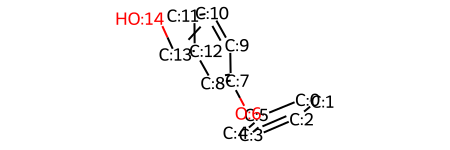

: 

: 

In [ ]:
inp = "0OO_4eh7"
# inp = "0RZ_4f1q"
key = inp.split("_")[0]
pdb_id=inp.split("_")[1]
lig_smi=ligands_smi[key][0]
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig_Block = exctract_ligand_from_pdb(pdb_path, key, lig_smi, f"{key}_{pdb_id}_sin.pdb")
test = Chem.RemoveAllHs(lig_Block)
mol_with_atom_index(test)

In [ ]:
test = phe2bch_topdb_debug(lig_smi, lig_Block, f"{key}_{pdb_id}_bch.pdb")
aligned_ligs = Chem.CombineMols(lig_Block, test)
drawit(aligned_ligs)

(6, 5, 4, 0, 3, 1, 2)
set atom idx 6
set atom idx 5
set atom idx 4
set atom idx 0
set atom idx 3
set atom idx 1
set atom idx 2
begin ((7, 8, 9, 13, 10, 12, 11),)
set()
begin4 ((7, 8, 9, 13, 10, 12, 11),)
end (7, 8, 9, 13, 10, 12, 11)
(7, 8, 9, 13, 10, 12, 11)
(0, 1, 2, 6, 3, 5, 4)
0      i
1      i
2      i
6      i
3      i
5      i
4      i
(14, 13)
set atom idx 14
set atom idx 13
begin ((0, 1), (7, 6), (7, 8))
{7, 8, 9, 10, 11, 12, 13}
begin3 ((0, 1), (7, 6), (7, 8))
end (0, 1)
(0, 1)
(0, 1)
0      i
1      i


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

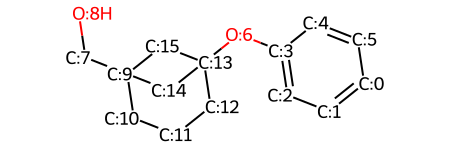

: 

: 

In [ ]:
mol = Phe2BCH.phe2bch_with_smiles(lig_smi)
# AllChem.EmbedMolecule(mol, maxAttempts=5000)
# drawit(mol)
smi_debug = "OC"
mol_bug = Chem.MolFromSmiles(smi_debug)
core = Chem.MolFromSmiles("C12CCCC(C2)C1")
# mol.GetSubstructMatches(core)
mol_with_atom_index(mol)

In [ ]:
matching = mol.GetSubstructMatch(core)
mol_test = Chem.EditableMol(mol)
for idx in matching:
    neighbors = mol.GetAtomWithIdx(idx).GetNeighbors()
    if len(neighbors) == 4:
        for atom in neighbors:
            if atom.GetIdx() not in matching:
                end_idx = atom.GetIdx()
        mol_test.RemoveBond(idx,end_idx)


: 

: 

In [ ]:
side_chains, unmatched = rdRGD.RGroupDecompose([core], [mol])
print(side_chains[0]["R1"].GetNumAtoms())
side_chains_reorder = [side_chains[0]["R1"],side_chains[0]["R2"]] if side_chains[0]["R1"].GetNumAtoms()>side_chains[0]["R2"].GetNumAtoms() else [side_chains[0]["R2"],side_chains[0]["R1"]]
for side_chain in side_chains_reorder:
    print(side_chain.GetNumAtoms())


3
8
3


: 

: 

In [ ]:
arranged_atoms = set()
for sidechain in side_chains_reorder:
    # sidechain_conf = sidechain.GetConformer()
    mcs_mid2inp = rdFMCS.FindMCS(
            [mol, sidechain],
            timeout=3,
            bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        )
    matches = mol.GetSubstructMatches(mcs_mid2inp.queryMol)
    if len(matches) > 1 and arranged_atoms:
        print(arranged_atoms)
        for match in matches:
            print(f"match {set(match)}")
            if set(match) & arranged_atoms == set(match):
                print(match)
                pass
            else:
                match_to_use = match
                break 

    else:
        match_to_use = matches[0]
    print(f"test {match_to_use}")
    for i, j in zip(
            sidechain.GetSubstructMatch(mcs_mid2inp.queryMol),
            match_to_use,
        ):
        print(f"{i} {j} ")
        arranged_atoms.add(i)



test (0, 1, 5, 2, 4, 3, 6)
0 0 
1 1 
5 5 
2 2 
4 4 
3 3 
6 6 
{0, 1, 2, 3, 4, 5, 6}
match {3, 6}
(3, 6)
match {8, 7}
test (7, 8)
0 7 
1 8 


: 

: 

In [ ]:
inp = "07Q_3tv7"
key = inp.split("_")[0]
pdb_id=inp.split("_")[1]
lig_smi=ligands_smi[key][0]
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig_Block = exctract_ligand_from_pdb(pdb_path, key, lig_smi, f"{key}_{pdb_id}_sin.pdb")
test = phe2bch_topdb_debug(lig_smi, lig_Block, f"{key}_{pdb_id}_bch.pdb")
aligned_ligs = Chem.CombineMols(lig_Block, test)
drawit(aligned_ligs)

IndexError: tuple index out of range

: 

: 

In [ ]:
drawit(test)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

In [ ]:
def get_connecter(mol,patt):
    core_connecter = []
    side_connecter = []
    match_patt = mol.GetSubstructMatches(patt)
    match_set = set(match_patt[0])
    for idx in match_patt[0]:
        atom = mol.GetAtomWithIdx(idx)
        neighbors = {neighbor.GetIdx() for neighbor in atom.GetNeighbors()}
        if neighbors & match_set == neighbors:
            pass
        else:
            side_connecter.append(idx)
            for i in list(neighbors):
                if i in match_set:
                    core_connecter.append(i)
    return [core_connecter,side_connecter]


: 

: 

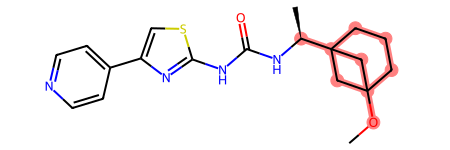

: 

: 

In [ ]:
remol = Phe2BCH.phe2bch_with_smiles(lig_smi)
core = Chem.MolFromSmarts("*C12CCCC(*)(C2)C1")
remol.GetSubstructMatch(core)
remol

[1, 8]
[2, 6]
((0, 1), (1, 2), (8, 6), (8, 9), (16, 19))


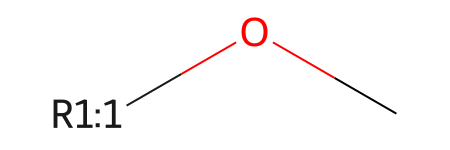

: 

: 

In [ ]:
mol = Chem.MolFromSmiles(lig_smi)
remol = Phe2BCH.phe2bch_with_smiles(lig_smi)
core = Chem.MolFromSmiles("C12CCCC(C2)C1")
side_chains, unmatched = rdRGD.RGroupDecompose([core], [remol])

mol_sidechain = side_chains[0]['R1'] 

mcs = rdFMCS.FindMCS([mol,mol_sidechain],bondCompare=rdFMCS.BondCompare.CompareAny,atomCompare=rdFMCS.AtomCompare.CompareAnyHeavyAtom)
# print(mol.GetSubstructMatches(mcs.queryMol))

match = mol.GetSubstructMatches(mcs.queryMol)
# print(Phe2BCH.get_connect_atom_in_sidechain(mol,match[0]))
patt = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
connecters = get_core_connecter(mol, patt)
print(match)
mol_sidechain

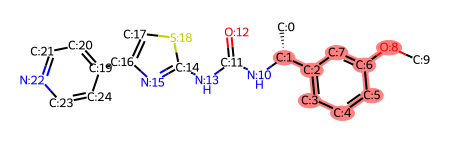

: 

: 

In [ ]:
mol_with_atom_index(mol)

In [ ]:
def get_connecter(mol,patt):
    core_connecter = []
    side_connecter = []
    match_patt = mol.GetSubstructMatches(patt)
    match_set = set(match_patt[0])
    for idx in match_patt[0]:
        atom = mol.GetAtomWithIdx(idx)
        neighbors = {neighbor.GetIdx() for neighbor in atom.GetNeighbors()}
        if neighbors & match_set == neighbors:
            pass
        else:
            side_connecter.append(idx)
            for i in list(neighbors):
                if i in match_set:
                    core_connecter.append(i)
    return [set(core_connecter),set(side_connecter)]

def get_correct_match(mol_whole, mcs, arranged_atoms, core_mol, debug):
    correct_matches = mol_whole.GetSubstructMatches(mcs.queryMol)
    if debug:
        print(f"begin {correct_matches}")
        print(arranged_atoms)
    if not arranged_atoms and len(correct_matches) > 1:
        if debug:
            print(f"begin2 {correct_matches}")
        # arranged_atoms is not empty means it is the first bigger group to match
        # however, the len(correct_matches) > 1 means the bigger group is not 
        # big enough to match only one part of the refmol
        # In that situation, we need to select the correct part of the molecule.
        core_head, side_head = get_connecter(mol_whole,core_mol)
        print(core_head)
        print(side_head)
        for match_correct in correct_matches:
            print(set(match_correct) & core_head)
            print(set(match_correct) & side_head)
            print(set(match_correct) & core_head)
            if set(match_correct) & core_head == set() and set(match_correct) & side_head != side_head:
                match_to_use = match_correct
    elif len(correct_matches) > 1 and arranged_atoms:
        if debug:
            print(f"begin3 {correct_matches}")
        for match_correct in correct_matches:
            if set(match_correct) & arranged_atoms != set():
                pass
            else:
                match_to_use = match_correct
                break 
    else:
        if debug:
            print(f"begin4 {correct_matches}")
        match_to_use = correct_matches[0]
    if debug:
        print(f"end {match_to_use}")
    return match_to_use


mol = Chem.MolFromSmiles(lig_smi)
remol = Phe2BCH.phe2bch_with_smiles(lig_smi)
core = Chem.MolFromSmiles("C12CCCC(C2)C1")
side_chains, unmatched = rdRGD.RGroupDecompose([core], [remol])
mol_edit = Chem.EditableMol(side_chains[0]['R2'])
mol_sidechain = side_chains[0]['R2'] 
print(mol_sidechain.GetNumAtoms())
for item in mol_sidechain.GetAtoms():
    if 'R' in item.GetSymbol():
        mol_edit.RemoveAtom(item.GetIdx())
mol_mcs = mol_edit.GetMol()
Chem.SanitizeMol(mol_mcs)
mcs = rdFMCS.FindMCS([mol,mol_mcs],bondCompare=rdFMCS.BondCompare.CompareAny,atomCompare=rdFMCS.AtomCompare.CompareAnyHeavyAtom)
# print(mol.GetSubstructMatches(mcs.queryMol))
patt = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
match = mol.GetSubstructMatches(mcs.queryMol)
get_correct_match(mol, mcs, set(), patt, True)


18
begin ((0, 1, 10, 11, 12, 13, 14, 15, 18, 16, 17, 19, 20, 24, 21, 23, 22), (2, 1, 10, 11, 12, 13, 14, 15, 18, 16, 17, 19, 20, 24, 21, 23, 22))
set()
begin2 ((0, 1, 10, 11, 12, 13, 14, 15, 18, 16, 17, 19, 20, 24, 21, 23, 22), (2, 1, 10, 11, 12, 13, 14, 15, 18, 16, 17, 19, 20, 24, 21, 23, 22))
{2, 6}
{8, 1}
set()
{1}
{2}
{1}
end (0, 1, 10, 11, 12, 13, 14, 15, 18, 16, 17, 19, 20, 24, 21, 23, 22)


(0, 1, 10, 11, 12, 13, 14, 15, 18, 16, 17, 19, 20, 24, 21, 23, 22)

: 

: 

In [ ]:
check_pdb = Chem.MolFromPDBFile("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/scripts/B74_6xic_bch.pdb",flavor=1)
drawit(check_pdb)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

In [ ]:
from Phe2BCH import *


ligands_smi = {}
with open(
    "/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/lig_menu/AaaaA_only3.csv"
) as AaaaA:
    for line in AaaaA:
        info = line.split()
        ligands_smi[info[1]] = [info[0]]
# inp = "0FS_3vc4" segmentation fault

AaaaA_core = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
bch_core = Chem.MolFromSmiles("C12CCCC(C2)C1")
def get_connecter(mol,patt):
    core_connecter = []
    side_connecter = []
    match_patt = mol.GetSubstructMatches(patt)
    match_set = set(match_patt[0])
    for idx in match_patt[0]:
        atom = mol.GetAtomWithIdx(idx)
        neighbors = {neighbor.GetIdx() for neighbor in atom.GetNeighbors()}
        if neighbors & match_set == neighbors:
            if len(list(neighbors)) == 1:
                side_connecter.append(idx)
                core_connecter.append(list(neighbors)[0]) 
            pass
        else:
            side_connecter.append(idx)
            for i in list(neighbors):
                if i in match_set:
                    core_connecter.append(i)
    return [set(core_connecter),set(side_connecter),set(match_patt[0])-set(core_connecter)-set(side_connecter)]



: 

: 

In [ ]:
def get_correct_match(mol_whole, mcs, arranged_atoms, core_mol, debug):
    match_to_use = False
    correct_matches = mol_whole.GetSubstructMatches(mcs.queryMol)
    print(f"test len{correct_matches}")
    if debug:
        print(f"begin {correct_matches}")
        print(arranged_atoms)
    if len(correct_matches) > 1:
        if debug:
            print(f"begin2 {correct_matches}")
        # arranged_atoms is not empty means it is the first bigger group to match
        # however, the len(correct_matches) > 1 means the bigger group is not 
        # big enough to match only one part of the refmol
        # In that situation, we need to select the correct part of the molecule.
        core_head, side_head, core_all = get_connecter(mol_whole,core_mol)
        for match_correct in correct_matches:
            if len(match_correct) == 1:
                # print(set(match_correct))
                # print(set(match_correct) & side_head)
                print(set(match_correct) & core_all)
                print(set(match_correct) & core_all != set())
            if set(match_correct) & core_head == set() and set(match_correct) & arranged_atoms == set() and set(match_correct) & core_all == set():
                if len(match_correct) == 1:
                    print("hello world")
                match_to_use = match_correct
    else:
        if debug:
            print(f"begin4 {correct_matches}")
        match_to_use = correct_matches[0]
    if debug:
        pass
    
    #    print(f"end {match_to_use}")
    if match_to_use:
        return match_to_use
    else:
        print("i really do not want")
        return correct_matches[0]

def getpdb_debug(refmol, inpmol, pdbfile):

    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol, inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)


    ref_arranged_atoms = set()
    inp_arranged_atoms = set()
    core = Chem.MolFromSmiles("C12CCCC(C2)C1")
    bch_core = Chem.MolFromSmarts("*C12CCCC(*)(C2)C1")
    phe_core = Chem.MolFromSmarts("*!:c1cc(!:*)ccc1")
    # bch_core_connect, bch_side_connect = get_connecter(inpmol,bch_core)
    # phe_core_connect, phe_side_connect = get_connecter(refmol,phe_core)

    side_chains, unmatched = rdRGD.RGroupDecompose([core], [inpmol])
    if side_chains[0]["R1"].GetNumAtoms()>side_chains[0]["R2"].GetNumAtoms():
        side_chains_reorder = [side_chains[0]["R1"],side_chains[0]["R2"]]  
    else:
        side_chains_reorder = [side_chains[0]["R2"],side_chains[0]["R1"]]
    
    for sidechain in side_chains_reorder:
        # Chem.SanitizeMol(sidechain)
    #    print(ref_arranged_atoms)
    #    print(inp_arranged_atoms)
        #for item in sidechain.GetAtoms():
        #    print(item.GetSymbol())
        sidechain_conf = sidechain.GetConformer()
        mcs1 = rdFMCS.FindMCS([refmol, sidechain], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny)
        mcs3 = rdFMCS.FindMCS([inpmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)

        sidechain_ref = get_correct_match(refmol,mcs1,ref_arranged_atoms,phe_core,False)
        sidechain_gen = get_correct_match(inpmol,mcs3,inp_arranged_atoms,bch_core,False)
        
        atom_connect_sidechain_core_ref = get_connect_atom_in_core(refmol, sidechain_ref)[0]
        atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]

        ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
        conf_res.SetAtomPosition(atom_connect_sidechain_core_gen,bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref),)
        
        mcs_ref2mid = rdFMCS.FindMCS([refmol, sidechain], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny)
        match_to_correct_ref = get_correct_match(refmol,mcs_ref2mid,ref_arranged_atoms,AaaaA_core,False)
    #    print(f"the result: {sidechain.GetSubstructMatches(mcs_ref2mid.queryMol)}")
        for i, j in zip(sidechain.GetSubstructMatch(mcs_ref2mid.queryMol),match_to_correct_ref,):
            sidechain_conf.SetAtomPosition(i, bonded_conf.GetAtomPosition(j))
            # print(f"set atom idx {i}")
            ref_arranged_atoms.add(j)
        # print(ref_arranged_atoms)
        mcs_mid2inp = rdFMCS.FindMCS(
            [inpmol, sidechain],
            timeout=3,
            bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        )
        match_to_correct_inp = get_correct_match(inpmol,mcs_mid2inp,inp_arranged_atoms,bch_core,True)
    #    print(match_to_correct_inp)
    #    print(f"sidechain {sidechain.GetSubstructMatches(mcs_mid2inp.queryMol)}")
        for i, j in zip(
            sidechain.GetSubstructMatch(mcs_mid2inp.queryMol),
            match_to_correct_inp
        ):  
    #        print(f"{i}      i")
            ff_mcs.AddFixedPoint(j)
            conf_res.SetAtomPosition(j,sidechain_conf.GetAtomPosition(i))
            inp_arranged_atoms.add(j)

    for i in range(10):
        try:
            ff_mcs.Minimize()
        except:
            pass

    inpmol = Chem.AddHs(inpmol, addCoords=True)
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol

def phe2bch_topdb_debug(smi0, refpdb, name):
    mol = phe2bch_with_smiles(smi0)
    ## Totally can not understand
    # here must mol to smi to mol
    # otherwise, the Allchem.EmbedMolecule may be
    # Segmentation fault
    # the bug detail is the "0FS_3vc4"
    smi = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # print("test")
    mol = Chem.RemoveAllHs(mol)

    structure_from_pdb = refpdb
    structure_from_pdb.GetConformer()
    try:
        structure_refine = Chem.RemoveAllHs(structure_from_pdb)
    except:
        structure_refine = Chem.RemoveHs(structure_from_pdb, implicitOnly=True)
    # some ligand can not remove all H
    structure_from_pdb.GetConformer()
    # print("test")
    return getpdb_debug(structure_refine, mol, f"{name}")

# print("test")
inp = "0OO_4eh7"
# inp = "0RZ_4f1q"
# inp = "07Q_3tv7"
# inp = "B74_6xic"
inp = "JJM_5qei"
key = inp.split("_")[0]
pdb_id = inp.split("_")[1]
lig_smi = ligands_smi[key][0]
# print(lig_smi)
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
# print(pdb_path)
lig_Block = exctract_ligand_from_pdb(pdb_path, key, lig_smi, f"{key}_{pdb_id}_sin.pdb")
test = phe2bch_topdb_debug(lig_smi, lig_Block, f"{key}_{pdb_id}_bch.pdb")

test len((17, 12, 11, 13, 10, 14, 9, 15, 8, 16, 7),)
test len((0, 1, 2, 18, 3, 17, 4, 16, 5, 15, 6),)
test len((17, 12, 11, 13, 10, 14, 9, 15, 8, 16, 7),)
test len((0, 1, 2, 18, 3, 17, 4, 16, 5, 15, 6),)
begin ((0, 1, 2, 18, 3, 17, 4, 16, 5, 15, 6),)
set()
begin4 ((0, 1, 2, 18, 3, 17, 4, 16, 5, 15, 6),)
test len((0,), (1,), (2,), (3,), (4,), (5,), (6,), (8,), (9,), (10,), (13,), (15,), (17,))
set()
False
hello world
set()
False
{2}
True
{3}
True
{4}
True
set()
False
{6}
True
set()
False
set()
False
set()
False
set()
False
set()
False
set()
False
test len((0,), (3,), (4,), (5,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (16,), (18,))
set()
False
set()
False
set()
False
set()
False
set()
False
{8}
True
{9}
True
{10}
True
set()
False
set()
False
hello world
{13}
True
{14}
True
set()
False
set()
False
test len((0,), (1,), (2,), (3,), (4,), (5,), (6,), (8,), (9,), (10,), (13,), (15,), (17,))
set()
False
hello world
set()
False
{2}
True
{3}
True
{4}
True
set()
False
{6}
True
set()

: 

: 

In [ ]:
aligned = Chem.CombineMols(lig_Block,test)
drawit(aligned)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

[{16, 12}, {0, 1}, {13, 14, 15, 17, 18}]
test len((0,), (2,), (3,), (4,), (7,), (9,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,))
set()
False
hello world
set()
False
set()
False
set()
False
set()
False
set()
False
set()
False
set()
False
{13}
True
{14}
True
{15}
True
set()
False
{17}
True
{18}
True
res
(0,)


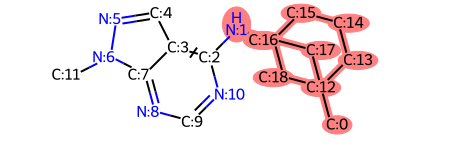

: 

: 

In [ ]:
test_mol = phe2bch_with_smiles(lig_smi)
mcs_mol = Chem.MolFromSmiles("C")
mcs = rdFMCS.FindMCS([test_mol, mcs_mol], timeout=3, bondCompare=rdFMCS.BondCompare.CompareAny)
print(get_connecter(test_mol,Chem.MolFromSmarts("*C12CCCC(*)(C2)C1")))
sidechain_ref = get_correct_match(test_mol,mcs,{2,3,4,5,6,7,8,9,10,11},Chem.MolFromSmarts("*C12CCCC(*)(C2)C1"),False)
print("res")
print(sidechain_ref)
mol_with_atom_index(test_mol)


In [ ]:
test = Chem.MolFromPDBFile("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/lig_bch_refine/0FS/3vc4/0FS_3vc4_phe.pdb")
drawit(test)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

In [ ]:
inp = "0FS_3vc4"
key = inp.split("_")[0]
pdb_id = inp.split("_")[1]
lig_smi = ligands_smi[key][0]
# print(lig_smi)
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
# print(pdb_path)
lig_Block = exctract_ligand_from_pdb(pdb_path, key, lig_smi, f"{key}_{pdb_id}_sin.pdb")
test = phe2bch_topdb_debug(lig_smi, lig_Block, f"{key}_{pdb_id}_bch.pdb")

(14, 8, 7, 9, 6, 10, 13, 12)
set atom idx 14
set atom idx 8
set atom idx 7
set atom idx 9
set atom idx 6
set atom idx 10
set atom idx 13
set atom idx 12
begin ((0, 1, 2, 18, 3, 5, 4, 6),)
set()
begin4 ((0, 1, 2, 18, 3, 5, 4, 6),)
end (0, 1, 2, 18, 3, 5, 4, 6)
(0, 1, 2, 18, 3, 5, 4, 6)
(0, 1, 2, 7, 3, 5, 4, 6)
0      i
1      i
2      i
7      i
3      i
5      i
4      i
6      i
(11, 15, 16, 17)
set atom idx 11
set atom idx 15
set atom idx 16
set atom idx 17
begin ((12, 13, 14, 15),)
{0, 1, 2, 3, 4, 5, 6, 18}
begin4 ((12, 13, 14, 15),)
end (12, 13, 14, 15)
(12, 13, 14, 15)
(0, 1, 2, 3)
0      i
1      i
2      i
3      i


: 

: 

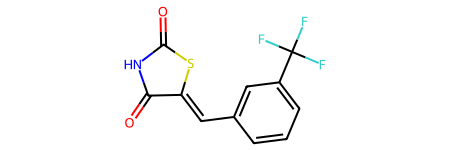

: 

: 

In [ ]:
mol_test = Chem.MolFromSmiles(lig_smi)
mol_test

In [ ]:
drawit(lig_Block)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

: 

In [11]:
pdb_view = Chem.MolFromPDBFile("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/scripts/test/11B_2pj5_bch.pdb")
drawit(pdb_view)

ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToMolBlock(NoneType)
did not match C++ signature:
    MolToMolBlock(RDKit::ROMol mol, bool includeStereo=True, int confId=-1, bool kekulize=True, bool forceV3000=False)